# Set Up for Project Imports


In [118]:
import sys
from pathlib import Path

In [119]:
source_directory = Path.cwd()
ROOT = source_directory.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

In [120]:
# DO NOT DELETE MIGHT NEED
# pandas.set_option("display.max_rows", 100_000)  # TOGGLE  UN/COMMENT
# pandas.reset_option("display.max_rows") # TOGGLE UN/COMMENT
# cleaned_uci_df['cityname'].value_counts(dropna=False)  # change column

In [121]:
# Auto-reload code changes
%load_ext autoreload
%autoreload 2

# Imports

In [122]:
from data.api import UcIrvineAPI, UcIrvineDatasetIDs, BureauEconomicAnalysisAPI
import data.wrangling_utils
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    median_absolute_error,
)

In [123]:
pandas.set_option('display.max_colwidth', None)  # show all text in cells
# pandas.set_option("display.max_rows", 100_000)
pandas.options.mode.copy_on_write = True
pandas.set_option('display.float_format', lambda x: '%.2f' % x)

# UcIrvine Data

In [124]:
uci = UcIrvineAPI.fetch_dataset(repo_id=UcIrvineDatasetIDs.Apartment_For_Rent_Classified.value)
uci_df: pandas.DataFrame = uci.data.original.reset_index()

/Users/Isaia/PycharmProjects/CS-577-07-Data-Science-Fall-2025-Project/.venv/lib/python3.12/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (0,5,6,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [125]:
uci_df.describe()

,index,price,latitude,longitude,time
count,99826.00,99821.00,99797.00,99795.00,99820.00
mean,49912.50,1527.21,31476.04,-91.56,1559689694.18
std,28817.43,903.64,7022820.00,15.82,11044865.59
min,0.00,100.00,19.57,-159.37,1544174418.00
25%,24956.25,1014.00,33.75,-104.79,1550831772.75
50%,49912.50,1350.00,37.23,-84.56,1568745091.50
75%,74868.75,1795.00,39.95,-77.59,1568767125.25
max,99825.00,52500.00,1568782042.00,-68.78,1577391425.00


In [126]:
clean_uci_df: pandas.DataFrame = data.wrangling_utils.clean(uci_df)

In [127]:
#select monthly price
cleaned_subset_df = clean_uci_df[clean_uci_df['price_type'] == 'monthly']

#select only these columns
cleaned_subset_df = cleaned_subset_df[['bathrooms', 'bedrooms', 'price', 'square_feet', 'state', 'latitude', 'longitude', 'cityname']]

cleaned_subset_df = cleaned_subset_df.dropna()

In [128]:
cleaned_subset_df.describe()

,bathrooms,bedrooms,price,square_feet,latitude,longitude
count,99014.00,99014.00,99014.00,99014.00,99014.00,99014.00
mean,1.42,1.73,1521.50,956.34,36.93,-91.58
std,0.53,0.75,889.14,364.96,4.61,15.83
min,1.00,0.00,100.00,107.00,19.57,-159.37
25%,1.00,1.00,1013.00,730.00,33.74,-104.82
50%,1.00,2.00,1350.00,900.00,37.18,-84.56
75%,2.00,2.00,1790.00,1116.00,39.95,-77.63
max,9.00,9.00,52500.00,12000.00,64.83,-68.78


In [129]:
percent_change = (1.0 - (cleaned_subset_df.shape[0] / uci_df.shape[0])) * 100
print(f"Percent change {percent_change:.3f}%")

Percent change 0.813%


In [130]:
cleaned_subset_df[['bathrooms', 'bedrooms', 'price', 'square_feet']].skew()

bathrooms      0.95
bedrooms       0.88
price         10.03
square_feet    3.73
dtype: float64

### Skewness Analysis
| Feature       | Skew     | Interpretation             | Action               |
| ------------- |----------|----------------------------|----------------------|
| `bathrooms`   | 0.95     | Slightly right-skewed        | Leave as-is discrete |
| `bedrooms`    | 0.88     | Slightly right-skewed      | Leave as-is discrete |
| `price`       | **9.87** | **Extremely right-skewed** | Must transform       |
| `square_feet` | **2.64** | **Strong right-skewed**    | Should transform     |


Data ranges from 0 to positive values only, so we will use a log-type transformation to reduce skewness.

Most of the dataset is small-to-moderate homes, but a handful of massive properties

In [131]:
cleaned_subset_df['price_log'] = np.log1p(cleaned_subset_df['price'])
cleaned_subset_df['square_feet_log'] = np.log1p(cleaned_subset_df['square_feet'])

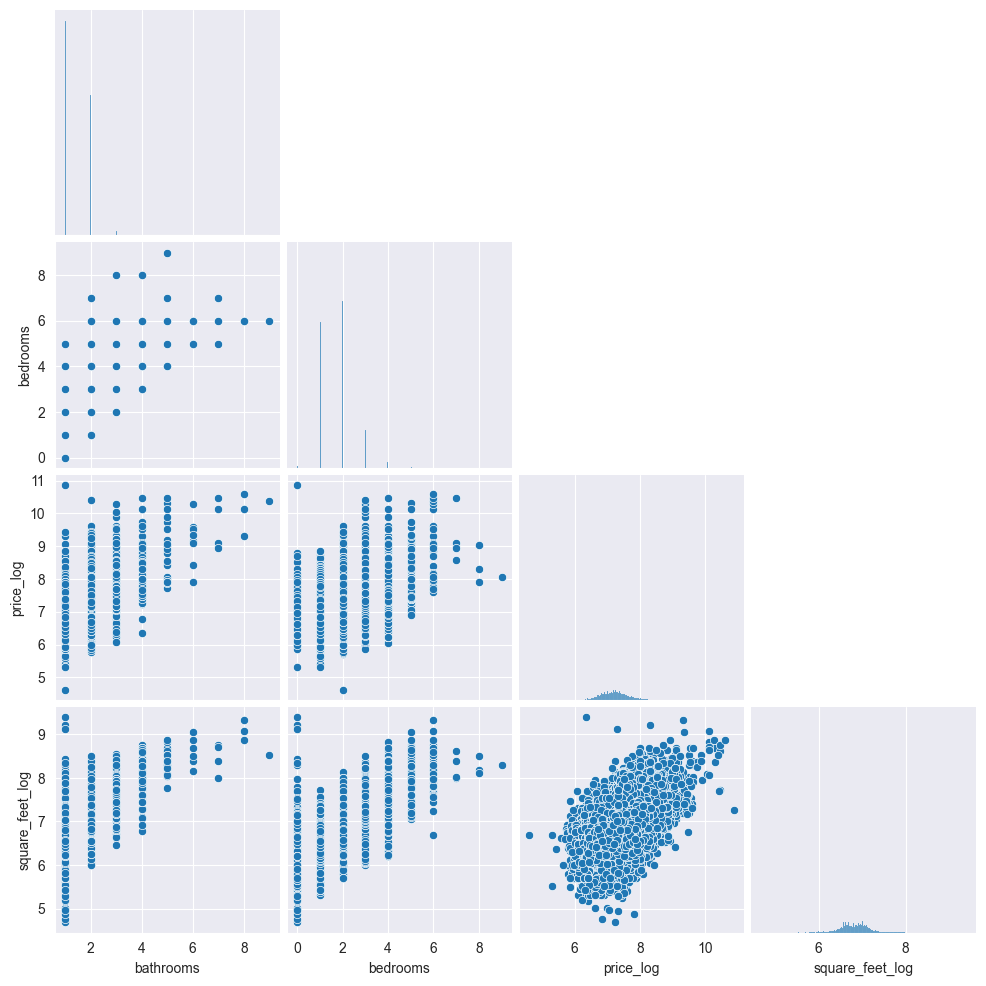

In [132]:
sns.pairplot(cleaned_subset_df[['bathrooms', 'bedrooms', 'price_log', 'square_feet_log']], kind='scatter', corner=True)

In [133]:
correlation = cleaned_subset_df[['bathrooms', 'bedrooms', 'price_log', 'square_feet_log']].corr(numeric_only=True)

In [134]:
correlation

,bathrooms,bedrooms,price_log,square_feet_log
bathrooms,1.00,0.66,0.34,0.70
bedrooms,0.66,1.00,0.25,0.70
price_log,0.34,0.25,1.00,0.40
square_feet_log,0.70,0.70,0.40,1.00


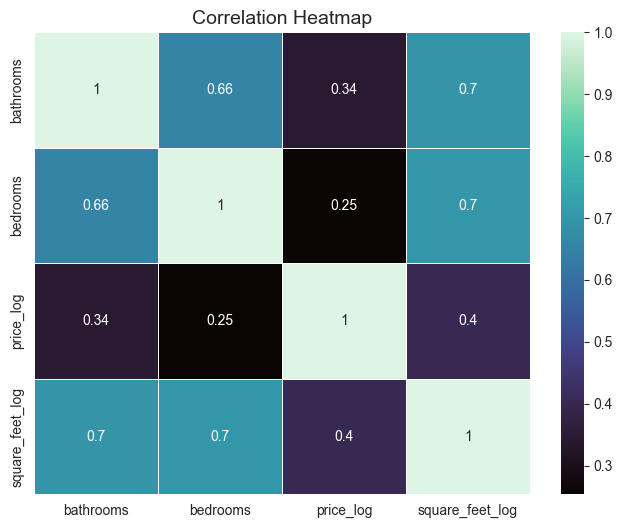

In [135]:
plt.figure(figsize=(8, 6))
plt.title("Correlation Heatmap", fontsize=14)
sns.heatmap(correlation, annot=True, linewidths=0.5, cmap='mako')
plt.show()

### Variable Types

- Discrete / ordinal: bedrooms, bathrooms — integer counts
- Continuous: price_log, square_feet_log — continuous and normalized
- We used Pearson correlation, the relationships involving discrete counts are approximate linear associations, not strict parametric correlations — but they’re still informative here since the discrete values are ordered and range reasonably (0–9).


| Pair                            | Correlation | Interpretation                                                                                                                                            |
| ------------------------------- | ----------- | --------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **bathrooms ↔ bedrooms**        | **0.66**    | Strong positive relationship — homes with more bedrooms usually have more bathrooms.                                                                      |
| **bathrooms ↔ square_feet_log** | **0.70**    | Strong positive correlation — larger houses naturally have more bathrooms.                                                                                |
| **bedrooms ↔ square_feet_log**  | **0.70**    | Same strong pattern — larger homes have more bedrooms.                                                                                                    |
| **price_log ↔ square_feet_log** | **0.40**    | Moderate positive relationship — price generally rises with size, but not perfectly (other factors matter).                                               |
| **price_log ↔ bathrooms**       | **0.34**    | Mild correlation — price increases somewhat with bathroom count, but not linearly.                                                                        |
| **price_log ↔ bedrooms**        | **0.25**    | Weak correlation — price doesn’t increase as predictably with bedroom count, possibly because extra bedrooms add less marginal value than square footage. |


In [136]:
clusterer = KMeans(n_clusters=30, random_state=42)
cleaned_subset_df['geo_cluster'] = clusterer.fit_predict(cleaned_subset_df[['latitude', 'longitude']])

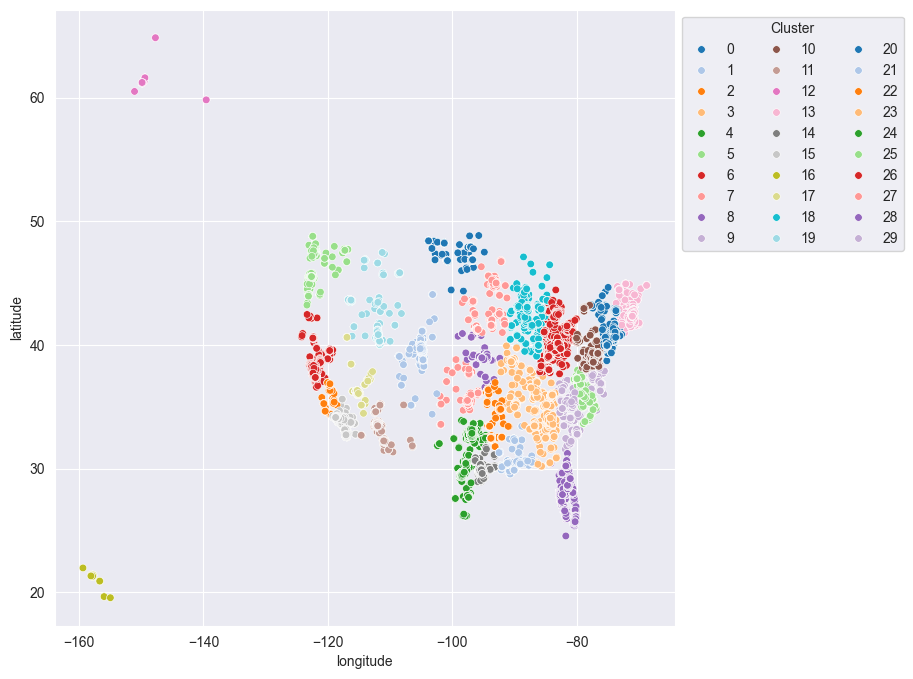

In [165]:
plt.figure(figsize=(8, 8))

ax = sns.scatterplot(
    data=cleaned_subset_df,
    x="longitude",
    y="latitude",
    hue="geo_cluster",
    palette="tab20",
    s=30
)

handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=labels,
    title="Cluster",
    ncol=3,
    bbox_to_anchor=(1,1),
    loc="upper left"
)

plt.show()

In [138]:
X = cleaned_subset_df[['square_feet_log', 'bedrooms', 'bathrooms', 'state', 'geo_cluster', 'cityname']]
y = cleaned_subset_df['price_log']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

preprocessor = ColumnTransformer([
    ("square_feet_log_poly", PolynomialFeatures(degree=2, include_bias=False), ['square_feet_log']),
    ('structura_linear', 'passthrough', ['bedrooms', 'bathrooms']),
    #("state_ohe", OneHotEncoder(handle_unknown='ignore'), ['state']),
    ('city_encoded', OneHotEncoder(handle_unknown='ignore'), ['cityname']),
    ('neighborhood_cluster_encoded', OneHotEncoder(handle_unknown='ignore'), ['geo_cluster'])
])

model = Pipeline([
    ('preprocess', preprocessor),
    ('linreg', LinearRegression()),
])


model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# ==========================
# 7. Metrics helper (includes Adjusted R²)
# ==========================
def adjusted_r2(y_true, y_pred, n_features: int) -> float:
    """Compute Adjusted R² given predictions and number of original features."""
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = n_features
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)


def print_regression_metrics(split_name, y_true, y_pred, n_features: int):
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(y_true, y_pred, n_features)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    med_ae = median_absolute_error(y_true, y_pred)

    print(f"=== {split_name} Metrics ===")
    print(f"R²:              {r2:.4f}")
    print(f"Adjusted R²:     {adj_r2:.4f}")
    print(f"MSE:             {mse:.4f}")
    print(f"RMSE:            {rmse:.4f}")
    print(f"MAE:             {mae:.4f}")
    print(f"MAPE:            {mape:.4f}")
    print(f"Median Abs Err:  {med_ae:.4f}")
    print()


# ==========================
# 8. Interpret real-world error from log-space metrics
# ==========================
def interpret_log_error_metrics(split_name, y_true, y_pred):
    """
    Interpret log-space error metrics in real price terms.
    Assumes y_true and y_pred are log(price).
    """
    rmse_log = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_log = mean_absolute_error(y_true, y_pred)
    med_ae_log = median_absolute_error(y_true, y_pred)

    # Convert log errors to multiplicative factors
    rmse_factor = np.exp(rmse_log)
    mae_factor = np.exp(mae_log)
    med_factor = np.exp(med_ae_log)

    rmse_pct = (rmse_factor - 1.0) * 100.0
    mae_pct = (mae_factor - 1.0) * 100.0
    med_pct = (med_factor - 1.0) * 100.0

    print(f"=== {split_name} Real-World Error Interpretation ===")
    print(f"Typical error (RMSE):    x {rmse_factor:.3f}  (predictions are typically off by ~{rmse_pct:.1f}% in true price)")
    print(f"Average error (MAE):     x {mae_factor:.3f}  (On average, predictions are off by ~{mae_pct:.1f}% in true price)")
    print(f"Typical core error (Median AE): x {med_factor:.3f}  (For half the homes, predictions are off within ~{med_pct:.1f}% in true price)")
    print()


# number of ORIGINAL features (bathrooms, bedrooms, sqft_log, state)
n_features = model.named_steps["preprocess"].transform(X_train).shape[1]

print_regression_metrics("Train", y_train, y_train_pred, n_features)
print_regression_metrics("Test",  y_test,  y_test_pred,  n_features)

interpret_log_error_metrics("Train", y_train, y_train_pred)
interpret_log_error_metrics("Test",  y_test,  y_test_pred)


=== Train Metrics ===
R²:              0.7838
Adjusted R²:     0.7759
MSE:             0.0411
RMSE:            0.2027
MAE:             0.1488
MAPE:            0.0206
Median Abs Err:  0.1114

=== Test Metrics ===
R²:              0.7581
Adjusted R²:     0.7180
MSE:             0.0463
RMSE:            0.2151
MAE:             0.1572
MAPE:            0.0219
Median Abs Err:  0.1185

=== Train Real-World Error Interpretation ===
Typical error (RMSE):    x 1.225  (predictions are typically off by ~22.5% in true price)
Average error (MAE):     x 1.160  (On average, predictions are off by ~16.0% in true price)
Typical core error (Median AE): x 1.118  (For half the homes, predictions are off within ~11.8% in true price)

=== Test Real-World Error Interpretation ===
Typical error (RMSE):    x 1.240  (predictions are typically off by ~24.0% in true price)
Average error (MAE):     x 1.170  (On average, predictions are off by ~17.0% in true price)
Typical core error (Median AE): x 1.126  (For half t

| Metric               | Train Value | Test Value | Interpretation                                                                                                                   |
| -------------------- | ----------- | ---------- |----------------------------------------------------------------------------------------------------------------------------------|
| **R²**               | 0.7838      | 0.7581     | % of variance explained. Model captures ~78% of training variation and ~76% of unseen variation **strong fit, low overfitting**. |
| **MSE**              | 0.0411      | 0.0463     | Average squared error. Test MSE only slightly higher **good generalization**.                                                    |
| **RMSE**             | 0.2027      | 0.2151     | Typical prediction error magnitude, ~20–21% deviation in normalized/log scale.                                                   |
| **MAE**              | 0.1488      | 0.1572     | Average absolute error, predictions off by ~15–16%.                                                                              |
| **MAPE**             | 0.0206      | 0.0219     | Mean Absolute Percentage Error ~2% if target is scaled, or ~2% error in/log space. Very low **consistent accuracy**.             |
| **Median Abs Error** | 0.1114      | 0.1185     | Half of predictions are within **11–12% error**. Indicates tight, stable core accuracy.                                          |


In [139]:
train_resid = y_train - y_train_pred
test_resid  = y_test  - y_test_pred

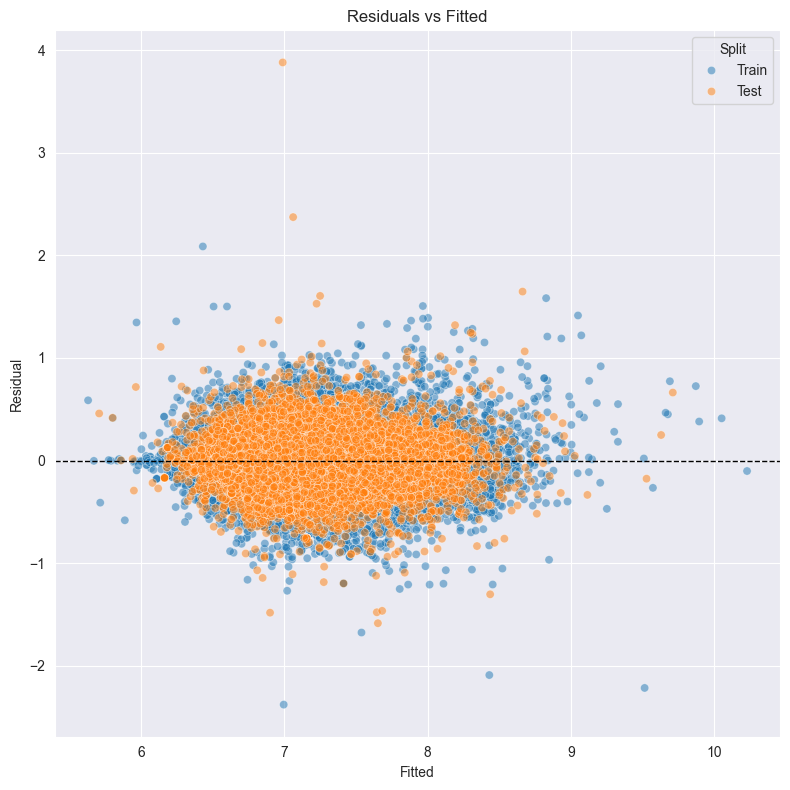

In [166]:
# Build DataFrames for easy plotting
train_df = pandas.DataFrame({
    "Fitted": y_train_pred,
    "Residual": train_resid,
    "Split": "Train"
})

test_df = pandas.DataFrame({
    "Fitted": y_test_pred,
    "Residual": test_resid,
    "Split": "Test"
})

resid_df = pandas.concat([train_df, test_df], ignore_index=True)

# Plot
plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=resid_df,
    x="Fitted",
    y="Residual",
    hue="Split",
    alpha=0.5
)

plt.axhline(0, linestyle="--", color="black", linewidth=1)
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

In [141]:
# DO NOT DELETE MIGHT NEED
# import json
# s = cleaned_uci_df['bathrooms'].explode()
# global_counts = s.value_counts().to_dict()
# global_counts
# print(f'BAD_DATA: {json.dumps(BAD_DATA['cityname'], indent=2)}')  # CHANGE COL
# uci_df["state_full"] = uci_df["state"].str.upper().map(STATE_MAP)
# print(uci_df.shape)
# uci_df.dropna(subset=["state_full"], inplace=True)
# uci_df.shape

<Axes: ylabel='state'>

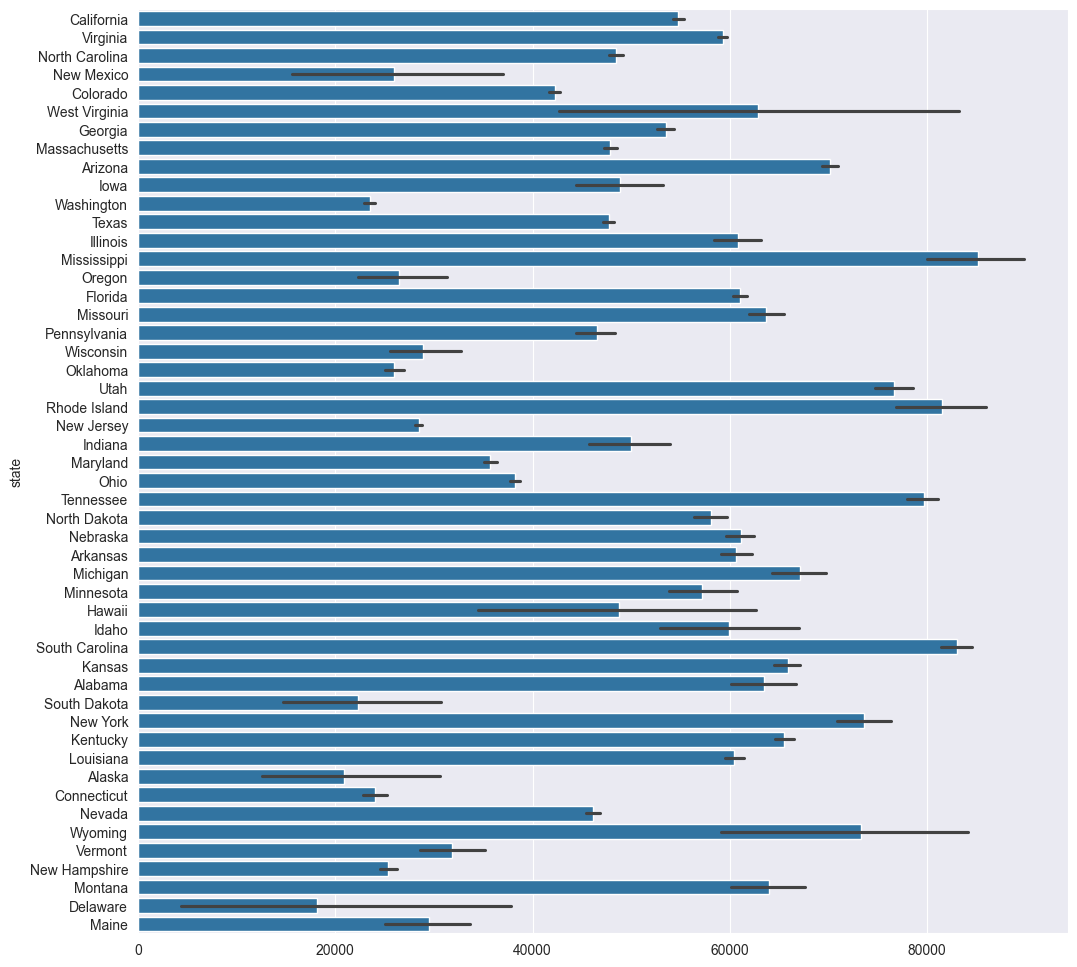

In [142]:
fig, axes = plt.subplots(1, 1, figsize=(12, 12))
sns.barplot(cleaned_subset_df['state'])

In [143]:
sources_df = clean_uci_df.groupby(['source']).agg(count=('source', 'count')).reset_index().sort_values(by='count', ascending=False)
sources_df[['source', 'count']].reset_index().head(5)

,index,source,count
0,17,rentdigs.com,91239
1,19,rentlingo,6924
2,9,listedbuy,571
3,5,gosection8,437
4,14,realrentals,269
